When working with gas systems I make intense use of the [WinCC-OA trending tool](https://www.winccoa.com/documentation/WinCCOA/3.18/en_US/GettingStarted/GettingStarted-60.html), which allows to plot up to 8 time series on the same panel. Each time series tpyically corresponds to the value read by a sensor of a plant so it may have different units and range. The trending tool allows to have multiple Y axes on the left side which can be adjusted in terms of range and offset.

I find this feature particularly helpful, especially when there is the need to quickly and explore and correlate readings of sensor from different parts of the plant

![WinCC-OA/UNICOS trending tool](./example_unicos.png)

Tools like matplotlib and plotly make it easy to work with multiple series plotted on the same data but I found a bit cumbersome trying to visualize data having
different scales on the same plot. 

Assuming we have a very simple set of $(x, y_n)$ series a simple plot with matplotlib may look like this:

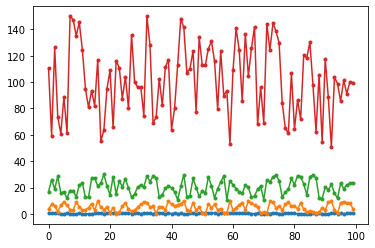

In [1]:
#| label: fig-multiple-series-same-plot
#| fig-cap: "A matplotlib plot with four series plotted together."

import matplotlib.pyplot as plt
import random as rnd

x = range(100)
y1 = [rnd.random() for i in x]
y2 = [rnd.random() * 10 for i in x]
y3 = [rnd.random() * 20 + 10 for i in x]
y4 = [rnd.random() * 100 + 50 for i in x]

fig, ax = plt.subplots()
for y in [y1, y2, y3, y4]:
    ax.plot(x, y, '.-')

Note that in Figure @fig-multiple-series-same-plot each time series has a different standard deviation, thus different ranges may be needed. This is often easily accomplished by plotting each series in a different subplots. However, subplots make it more difficult to visually compare and align series, especially when time-based. 
For example, see subplots here:

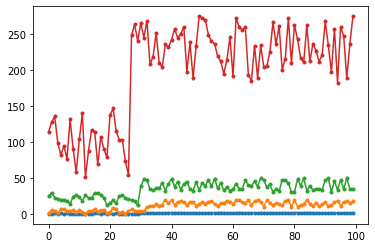

In [2]:
#| fig-cap: "Multiple series with an offset at arbitrary x."
x = range(100)
y1 = [rnd.random() if i < 30 else rnd.random() + 1 for i in x]
y2 = [rnd.random() * 10 if i < 33 else rnd.random() * 10 + 10 for i in x]
y3 = [rnd.random() * 20 + 10 if i < 30 else rnd.random() * 20 + 30 for i in x]
y4 = [rnd.random() * 100 + 50 if i < 27 else rnd.random() * 100 + 180 for i in x]

fig, ax = plt.subplots()
for y in [y1, y2, y3, y4]:
    ax.plot(x, y, '.-')

Here I have added an offset to each series. Two series, `y1` and `y3` have a change point at the same index, while the other two have a change point at slightly different `x`s. We could plot each series in a subplots, perhaps vertically stacked:

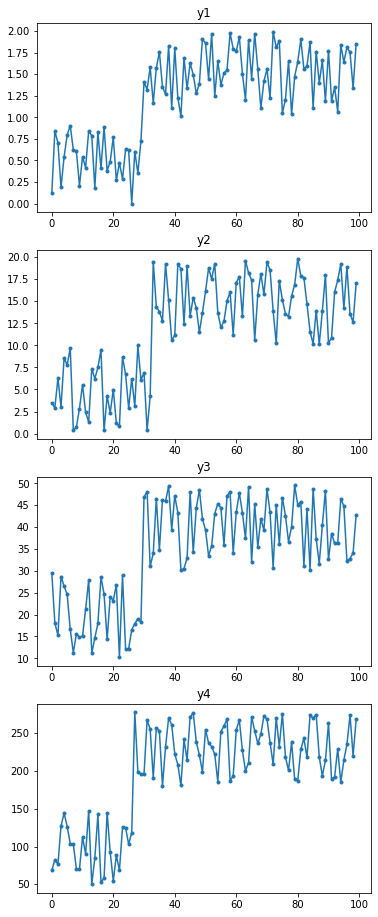

In [23]:
#| fig-cap: "Series plotted on different subplots."
#| label: fig-multiple-series-multiple-plots
series = [y1, y2, y3, y4]
fig, axs = plt.subplots(len(series), 1, figsize=(6, 4*len(series)))
for ix, y in enumerate(series):
    ax = axs.flat[ix]
    ax.plot(x, y, '.-')
    ax.set_title(f'y{ix+1}')

In figure @fig-multiple-series-multiple-plots you can see that each series as an offset when adding a proper range on the y axis. However, it is still a bit difficult to understand the real indexes of the offset. I would like to understand which come first and which comes later.

## Adding multiple Y axes to matplotlib plots

We can starting adding multiple axes by taking inspiration from the Matplotib documentation using [spines](https://matplotlib.org/stable/gallery/spines/multiple_yaxis_with_spines.html), [Parasite Axes](https://matplotlib.org/stable/gallery/axisartist/demo_parasite_axes.html) and another [Parasite axis](https://matplotlib.org/stable/gallery/axisartist/demo_parasite_axes2.html) demo.

The idea is to use `ax.twinx()` to create an additional axes. As the [documentation says](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html#matplotlib.axes.Axes.twinx), 
> Create a new Axes with an invisible x-axis and an independent y-axis positioned opposite to the original one (i.e. at right).

Although `twinx()` is used to create a secondary axis on the right position I could use it to create a secondary axis and leave the spines of the axis only on the left. I can use `set_position()` on the spines object to shift the spines on left:

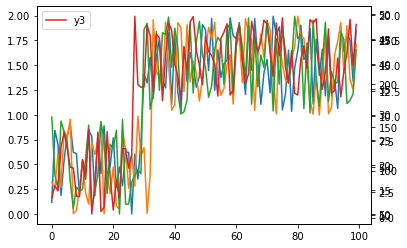

In [60]:
#| fig-cap: "Single plot with multiple series and secondary axes."
#| label: fig-single-plot-bare-twinx

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax4 = ax1.twinx()
axs = [ax1, ax2, ax3, ax4]

for ix, (ax, y) in enumerate(zip(axs, series)):
    ax.plot(x, y, label=f'y{ix}', color=f'C{ix}')
ax.legend();

As you can see in Figure @fig-single-plot-bare-twinx we can understand the index at which each change point of the series is happening. The only issue is that the y axes on the right are overlapping between each other.


My goal is to have these secondary y-axes on the left for easier reading. Actually, if you inspect the source of how `twinx()` is defined, it calls `Axes._make_twin_axes()` and sets later the tick position on the right using `YAxis.tick_right()` and `YAxis.set_label_position('right')`. It would be nice
if `twinx()` would not assume that we want the axes to the right and instead allowed to pass a parameter which decised the position.

Here below I leave a minimum working example I could think of:

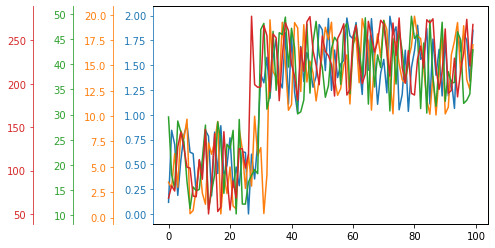

In [54]:
fig, axes = plt.subplots()
for ix, y in enumerate(series):
    # If we have to plot the first series we use 
    # The axes created by plt.subplots() earlier
    if ix == 0: 
        ax = axes
    else:
        # It's not the first series: we need to
        # create a twin axes
        ax = axes.twinx()
    # Set the ticks of the axis to the left
    ax.yaxis.tick_left()
    # Set the labels of the axes to the lef
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_offset_position('left')
    # Offset the position of he ticks and labels
    # by some % of the axes avoid overlapping of axes
    ax.spines['left'].set_position(('outward', 40 * ix))
    # Plot the actual data
    ax.plot(x, y, color=f'C{ix}')
    ax.spines['left'].set_color(f'C{ix}')
    ax.tick_params(axis='y', colors=f'C{ix}')


Et voilà, here I have a plot similar to the WinCC-OA one. I could improve the plot a bit by using the same number of ticks for each axes. I would do this using the `LinearLocator` class:

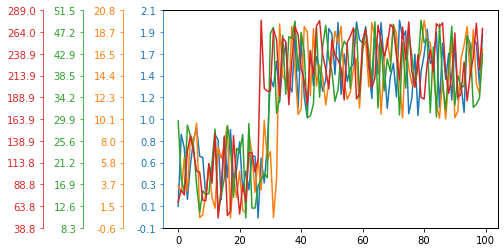

In [59]:
#| code-fold: true

import matplotlib.ticker as mt

fig, axes = plt.subplots()
for ix, y in enumerate(series):
    # If we have to plot the first series we use 
    # The axes created by plt.subplots() earlier
    if ix == 0: 
        ax = axes
    else:
        # It's not the first series: we need to
        # create a twin axes
        ax = axes.twinx()
    # Set the ticks of the axis to the left
    ax.yaxis.tick_left()
    # Set the labels of the axes to the left
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_offset_position('left')
    # Offset the position of he ticks and labels
    # by some % of the axes avoid overlapping of axes
    ax.spines['left'].set_position(('outward', 40 * ix))
    # Plot the actual data
    ax.plot(x, y, color=f'C{ix}')
    # Set the colors of the ticks, labels and spines to be
    # the same of the associated series
    ax.spines['left'].set_color(f'C{ix}')
    ax.tick_params(axis='y', colors=f'C{ix}')
    # Use a tick locator to have the same number of ticks
    ax.yaxis.set_major_locator(mt.LinearLocator(11))
    # And format the labels to have only one digit after the decimals
    ax.yaxis.set_major_formatter(mt.StrMethodFormatter('{x:.1f}'))


## Conclusions

I find very useful for myself to provide a minimal example of having a plot with multiple axes, though a final plot may require more subtle adjustements.
Keypoints to have multiple y axes:
* Use `twinx()` to create an additional axis
* Set ticks, labels and offest positions to the right: `ax.yaxis.tick_left()`, `ax.yaxis.set_label_position('left')`, `ax.yaxis.set_offset_position('left')`
* Adjust the offset of the spines to the left using points, percentage or data coordinate. In the case of points: `ax.spines['left'].set_position()`
* Change spines, tick and label colors to the same of the series for better readability: `ax.spines['left'].set_color(color)`, `ax.tick_params(axis='y', colors=color)`
* Optionally adjust the number of ticks to be the same for all the axes: use a `LinearLocator` class with a fixed number of points
